In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
%matplotlib inline

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [2]:
import sys
ipython = get_ipython()

def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
                      exception_only=False, running_compiled_code=False):
       etype, value, tb = sys.exc_info()
       return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))

ipython.showtraceback = hide_traceback

In [3]:
p = 331
d = 'image16'

img_rows, img_cols, img_channel = p, p, 3

base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))

In [4]:
add_model = tf.keras.Sequential()
add_model.add(tf.keras.layers.Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(tf.keras.layers.Dropout(rate = 0.8))
#add_model.add(tf.keras.layers.Dense(units=256, activation=tf.nn.relu))
add_model.add(tf.keras.layers.Dense(units=11, activation=tf.nn.softmax))

model = tf.keras.Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=1e-6),
              metrics=['accuracy'])

#model.summary()

In [5]:
batch_size = 8
epochs = 100

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)

train_set = train_datagen.flow_from_directory(d+'/train',
                                                 target_size = (p, p),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical')

val_set = val_datagen.flow_from_directory(d+'/val',
                                                 target_size = (p, p),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical')


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit_generator(
    train_set,
    steps_per_epoch= 4742 // batch_size,
    epochs=epochs,
    validation_data=val_set,
    validation_steps = 527 // batch_size,
    callbacks=[callback]
)

Found 4742 images belonging to 11 classes.
Found 527 images belonging to 11 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 592 steps, validate for 65 steps
Epoch 1/100
592/592 [==============================] - 236s 399ms/step - loss: 2.9765 - accuracy: 0.1035 - val_loss: 2.3908 - val_accuracy: 0.1442
Epoch 2/100
592/592 [==============================] - 231s 390ms/step - loss: 2.8302 - accuracy: 0.1257 - val_loss: 2.3602 - val_accuracy: 0.1365
Epoch 3/100
592/592 [==============================] - 232s 391ms/step - loss: 2.7223 - accuracy: 0.1278 - val_loss: 2.3274 - val_accuracy: 0.1846
Epoch 4/100
592/592 [==============================] - 233s 393ms/step - loss: 2.6433 - accuracy: 0.1515 - val_loss: 2.3073 - val_accuracy: 0.1942
Epoch 5/100
592/592 [==============================] - 233s 393ms/step - loss: 2.5508 - accuracy: 0.1692 - val_loss: 2.2964 - val_accuracy: 0.2096
Epoch 6/100

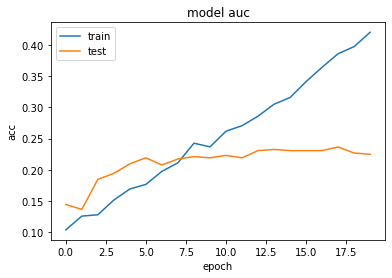

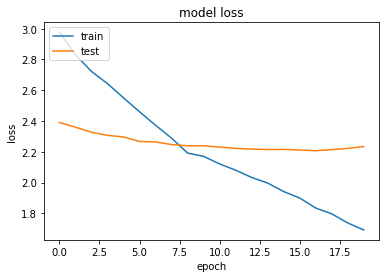

In [6]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model auc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [7]:
#d = "image12"
#p = 331
#batch_size = 8
#model = tf.keras.models.load_model('image12_model_1e_5_p3.h5')

In [8]:
test_set = test_datagen.flow_from_directory(d+'/test',
                                                 target_size = (p, p),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical')
score = model.evaluate(test_set, steps = 28501 // batch_size)

Found 28501 images belonging to 11 classes.
  ...
    to  
  ['...']
3562/3562 [==============================] - 282s 79ms/step - loss: 2.0183 - accuracy: 0.3691


In [ ]:
test_set = test_datagen.flow_from_directory(d+'/test',
                                                 target_size = (p, p),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                shuffle=False)
preds = model.predict(test_set, steps = 28501 // batch_size)
a = test_set.classes

Found 28501 images belonging to 11 classes.


In [ ]:
y_test = np.zeros((a.size, a.max()+1))
y_test[np.arange(a.size),a] = 1

In [ ]:
y_test = y_test[:-(28501%batch_size)]

In [ ]:
def LIFT(preds, y_test, cls): # >=2.5
    condition = y_test.astype(bool) #preds에 정답인 예측 score만 남긴다.
    c = np.extract(condition, preds)
    b = np.argsort(-c)[:len(c)//5] #예측 score 상위 20%
    
    lift_20 = preds[b] 
    
    lift_20_flat = np.argmax(lift_20, axis=1) #값을 확률에서 0, 1값으로 바꾼다. 
    y_test_flat = np.argmax(y_test, axis=1)
    lift_20_1 = lift_20_flat[lift_20_flat == cls] #1인 경우만 남긴다. 
    y_1 = y_test_flat[y_test_flat == cls]
    
    lift_score = (len(lift_20_1)/len(lift_20_flat))/(len(y_1)/len(y_test_flat))
    print('LIFT Accuracy: ',  lift_score)
    return lift_score

In [ ]:
lift_score = [0, 0, 0]
lift_score[0] = LIFT(preds, y_test, 3)
lift_score[1] = LIFT(preds, y_test, 4)
lift_score[2] = LIFT(preds, y_test, 7)
avg_lift = sum(lift_score) / 3

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in [3, 4, 7]:
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
avg_auroc = sum([roc_auc[3], roc_auc[4], roc_auc[7]]) / 3

In [ ]:
final_score = (avg_lift)*0.7 + (avg_auroc)*0.3
print(avg_lift, avg_auroc, final_score)

In [ ]:
#model.save('model.h5')

In [ ]:
#model = tf.keras.models.load_model('model.h5')